In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import shutil

In [3]:
from src.nn.DVPDESolver import DVPDESolver
from src.nn.CVPDESolver import CVPDESolver
from src.nn.ClassicalSolver import ClassicalSolver
from src.utils.logger import Logging
from src.nn.pde import wave_operator
from src.utils.plot_prediction import plt_prediction
from src.data.wave_dataset import u, r
from src.data.wave_dataset import Sampler

In [4]:
log_path = "./testing_checkpoints"
logger = Logging(log_path)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
torch.cuda.is_available()

True

## Generate Training Dataset


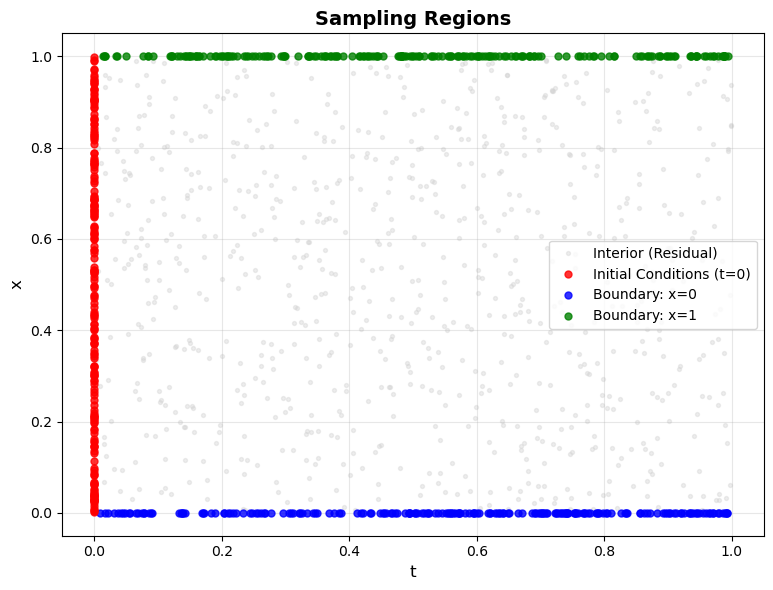

Dataset Overview:
• Parameters: a = 0.5, c = 2.0
• Domain: t ∈ [0,1], x ∈ [0,1]
• Wave equation: ∂²u/∂t² = c²∂²u/∂x²


In [6]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Your original classes and functions
class Sampler:
    def __init__(self, dim, coords, func, device="cpu"):
        self.dim = dim
        self.coords = torch.tensor(
            coords, dtype=torch.float32, device=device
        )
        self.func = func
        self.device = device

    def sample(self, N):
        rand_vals = torch.rand(N, self.dim, dtype=torch.float32, device=self.device)
        x = (
            self.coords[0:1, :]
            + (self.coords[1:2, :] - self.coords[0:1, :]) * rand_vals
        )
        y = self.func(x)
        return x, y

def u(x, a, c):
    """Analytical solution: u(t,x) - wave-like function"""
    t = x[:, 0:1]
    x = x[:, 1:2]
    return torch.sin(
        torch.tensor(np.pi, dtype=torch.float32, device=x.device) * x
    ) * torch.cos(
        c * torch.tensor(np.pi, dtype=torch.float32, device=x.device) * t
    ) + a * torch.sin(
        2 * c * torch.tensor(np.pi, dtype=torch.float32, device=x.device) * x
    ) * torch.cos(4 * c * torch.tensor(np.pi, dtype=torch.float32, device=x.device) * t)

def u_tt(x, a, c):
    t = x[:, 0:1]
    x = x[:, 1:2]
    pi = torch.tensor(np.pi, dtype=torch.float32, device=x.device)
    u_tt = -((c * pi) ** 2) * torch.sin(pi * x) * torch.cos(c * pi * t) - a * (
        4 * c * pi
    ) ** 2 * torch.sin(2 * c * pi * x) * torch.cos(4 * c * pi * t)
    return u_tt

def u_xx(x, a, c):
    t = x[:, 0:1]
    x = x[:, 1:2]
    pi = torch.tensor(np.pi, dtype=torch.float32, device=x.device)
    u_xx = -(pi**2) * torch.sin(pi * x) * torch.cos(c * pi * t) - a * (
        2 * c * pi
    ) ** 2 * torch.sin(2 * c * pi * x) * torch.cos(4 * c * pi * t)
    return u_xx

def r(x, a, c):
    """Residual of the wave equation: u_tt - c^2 * u_xx"""
    return u_tt(x, a, c) - c**2 * u_xx(x, a, c)

def generate_training_dataset(device):
    a = torch.tensor(0.5, dtype=torch.float32, device=device)
    c = torch.tensor(2.0, dtype=torch.float32, device=device)

    ics_coords = np.array([[0.0, 0.0], [0.0, 1.0]], dtype=np.float32)
    bc1_coords = np.array([[0.0, 0.0], [1.0, 0.0]], dtype=np.float32)
    bc2_coords = np.array([[0.0, 1.0], [1.0, 1.0]], dtype=np.float32)
    dom_coords = np.array([[0.0, 0.0], [1.0, 1.0]], dtype=np.float32)

    ics_sampler = Sampler(2, ics_coords, lambda x: u(x, a, c), device=device)
    bc1 = Sampler(2, bc1_coords, lambda x: u(x, a, c), device=device)
    bc2 = Sampler(2, bc2_coords, lambda x: u(x, a, c), device=device)
    bcs_sampler = [bc1, bc2]
    res_sampler = Sampler(2, dom_coords, lambda x: r(x, a, c), device=device)
    
    return [ics_sampler, bcs_sampler, res_sampler]

# Set up parameters
device = "cpu"
a = torch.tensor(0.5, dtype=torch.float32, device=device)
c = torch.tensor(2.0, dtype=torch.float32, device=device)

# Create the visualization
fig = plt.figure(figsize=(15, 6))

# 1. Sampling Regions
ax1 = plt.subplot(1, 2, 1)
plt.title('Sampling Regions', fontsize=14, fontweight='bold')

# Generate sample points for visualization
ics_sampler, bcs_sampler, res_sampler = generate_training_dataset(device)

# Sample points from each region
ics_points, _ = ics_sampler.sample(200)
bc1_points, _ = bcs_sampler[0].sample(200)
bc2_points, _ = bcs_sampler[1].sample(200)
res_points, _ = res_sampler.sample(800)

# Plot sampling regions
plt.scatter(res_points[:, 0], res_points[:, 1], c='lightgray', s=8, alpha=0.4, label='Interior (Residual)', zorder=1)
plt.scatter(ics_points[:, 0], ics_points[:, 1], c='red', s=25, alpha=0.8, label='Initial Conditions (t=0)', zorder=3)
plt.scatter(bc1_points[:, 0], bc1_points[:, 1], c='blue', s=25, alpha=0.8, label='Boundary: x=0', zorder=2)
plt.scatter(bc2_points[:, 0], bc2_points[:, 1], c='green', s=25, alpha=0.8, label='Boundary: x=1', zorder=2)

plt.xlabel('t', fontsize=12)
plt.ylabel('x', fontsize=12)
plt.legend(fontsize=10, loc='center right')
plt.grid(True, alpha=0.3)
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)


plt.tight_layout()
plt.show()

print("Dataset Overview:")
print(f"• Parameters: a = {a.item():.1f}, c = {c.item():.1f}")
print(f"• Domain: t ∈ [0,1], x ∈ [0,1]")
print(f"• Wave equation: ∂²u/∂t² = c²∂²u/∂x²")

## Generate Testing Dataset


In [7]:
a = torch.tensor(0.5, dtype=torch.float32, device=DEVICE)
c = torch.tensor(2.0, dtype=torch.float32, device=DEVICE)

# Domain boundaries - convert to float32
ics_coords = np.array([[0.0, 0.0], [0.0, 1.0]], dtype=np.float32)
bc1_coords = np.array([[0.0, 0.0], [1.0, 0.0]], dtype=np.float32)
bc2_coords = np.array([[0.0, 1.0], [1.0, 1.0]], dtype=np.float32)
dom_coords = np.array([[0.0, 0.0], [1.0, 1.0]], dtype=np.float32)

# Create initial conditions samplers
ics_sampler = Sampler(2, ics_coords, lambda x: u(x, a, c), device=DEVICE)

# Create boundary conditions samplers
bc1 = Sampler(2, bc1_coords, lambda x: u(x, a, c), device=DEVICE)
bc2 = Sampler(2, bc2_coords, lambda x: u(x, a, c), device=DEVICE)
bcs_sampler = [bc1, bc2]

# Create residual sampler
res_sampler = Sampler(2, dom_coords, lambda x: r(x, a, c), device=DEVICE)
coll_sampler = Sampler(2, dom_coords, lambda x: u(x, a, c), device=DEVICE)

# Create mesh grid with float32
nn = 30
t = np.linspace(dom_coords[0, 0], dom_coords[1, 0], nn, dtype=np.float32)[:, None]
x = np.linspace(dom_coords[0, 1], dom_coords[1, 1], nn, dtype=np.float32)[:, None]
t, x = np.meshgrid(t, x)

# Convert to PyTorch tensor with float32
X_star = (
    torch.hstack(
        (torch.from_numpy(t.flatten()[:, None]), torch.from_numpy(x.flatten()[:, None]))
    )
    .to(DEVICE)
    .to(torch.float32)
)


u_star = u(X_star, a, c)
f_star = r(X_star, a, c)

INFO:src.utils.logger:checkpoint path: self.log_path='testing_checkpoints/wave/2025-09-11_21-21-22-353528'
INFO:src.utils.logger:Total number of iterations : 20001
INFO:src.utils.logger:The final loss : 0.035788170993328094


Model state loaded from ./models/2025-02-24_20-00-46-837506/model.pth


INFO:src.utils.logger:Relative L2 error_u: 8.71e+00
INFO:src.utils.logger:Total number of parameters: 2751
INFO:src.utils.logger:Using DV Solver
INFO:src.utils.logger:Total number of iterations : 20001
INFO:src.utils.logger:The final loss : 0.12525874376296997
INFO:src.utils.logger:The circuit used in the study:


Model state loaded from ./models/2025-02-21_11-27-26-796633/model.pth
The circuit is saved in testing_checkpoints/wave/2025-09-11_21-21-22-353528


INFO:src.utils.logger:Relative L2 error_u: 1.04e+01
INFO:src.utils.logger:Total number of parameters: 771


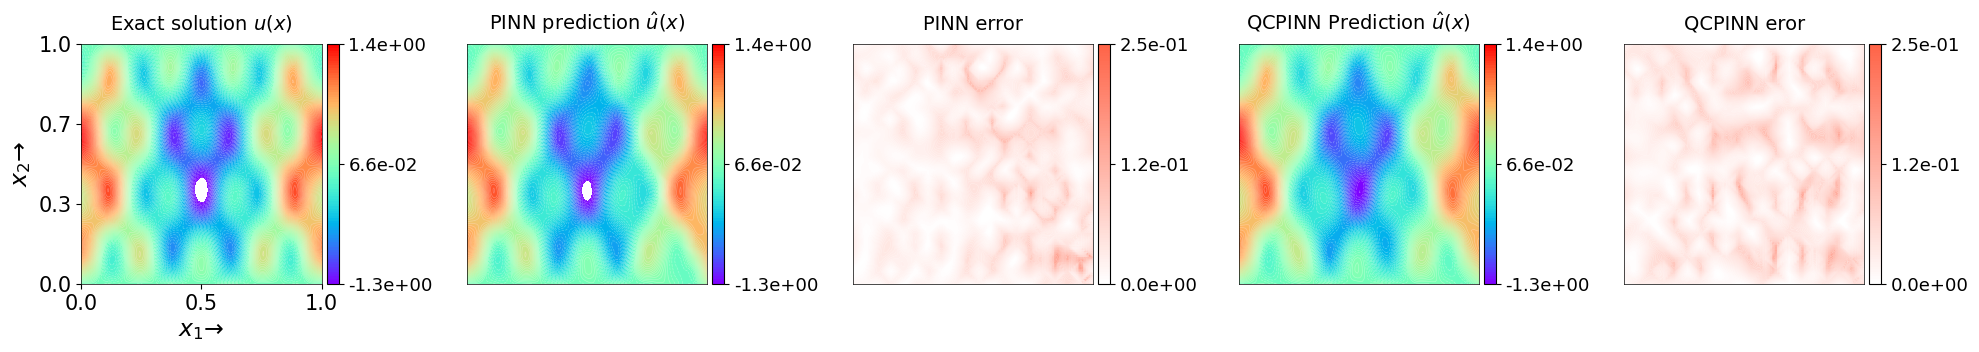


Loss values at iteration 12500:
----------------------------------------
classical           : 0.051791
angle_cascade       : 0.065036
----------------------------------------


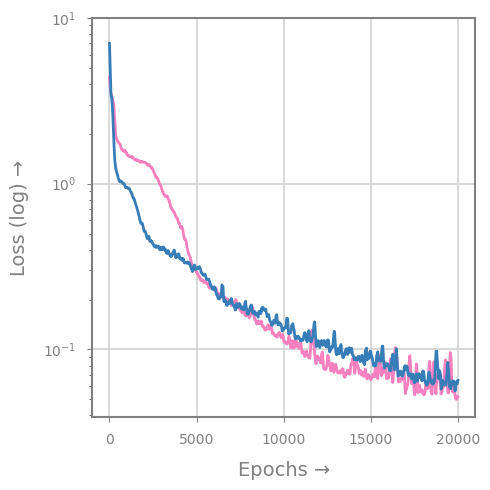

In [8]:
import numpy as np
import os
import torch

from src.utils.plot_loss import plot_loss_history
from src.nn.DVPDESolver import DVPDESolver
from src.nn.CVPDESolver import CVPDESolver
from src.utils.logger import Logging
from src.nn.pde import wave_operator
from src.utils.plot_model_results import plt_model_results
from src.data.wave_dataset import u, r
from src.nn.ClassicalSolver import ClassicalSolver
from src.data.wave_dataset import Sampler

log_path = "testing_checkpoints/wave"
logger = Logging(log_path)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Test data

a = torch.tensor(0.5, dtype=torch.float32, device=DEVICE)
c = torch.tensor(2.0, dtype=torch.float32, device=DEVICE)


# Domain boundaries - convert to float32
ics_coords = np.array([[0.0, 0.0], [0.0, 1.0]], dtype=np.float32)
bc1_coords = np.array([[0.0, 0.0], [1.0, 0.0]], dtype=np.float32)
bc2_coords = np.array([[0.0, 1.0], [1.0, 1.0]], dtype=np.float32)
dom_coords = np.array([[0.0, 0.0], [1.0, 1.0]], dtype=np.float32)

# Create initial conditions samplers
ics_sampler = Sampler(2, ics_coords, lambda x: u(x, a, c), device=DEVICE)

# Create boundary conditions samplers
bc1 = Sampler(2, bc1_coords, lambda x: u(x, a, c), device=DEVICE)
bc2 = Sampler(2, bc2_coords, lambda x: u(x, a, c), device=DEVICE)
bcs_sampler = [bc1, bc2]

# Create residual sampler
res_sampler = Sampler(2, dom_coords, lambda x: r(x, a, c), device=DEVICE)
coll_sampler = Sampler(2, dom_coords, lambda x: u(x, a, c), device=DEVICE)

# Create mesh grid with float32
number_of_points = 20
t = np.linspace(dom_coords[0, 0], dom_coords[1, 0], number_of_points, dtype=np.float32)[
    :, None
]
x = np.linspace(dom_coords[0, 1], dom_coords[1, 1], number_of_points, dtype=np.float32)[
    :, None
]
t, x = np.meshgrid(t, x)

# Convert to PyTorch tensor with float32
X_star = (
    torch.hstack(
        (torch.from_numpy(t.flatten()[:, None]), torch.from_numpy(x.flatten()[:, None]))
    )
    .to(DEVICE)
    .to(torch.float32)
)


u_star = u(X_star, a, c)
f_star = r(X_star, a, c)

# new angle cascade 2025-02-24_20-15-02-259948

# model_path_angle_cascade = (
#     "./log_files/checkpoints/wave/2025-02-24_20-15-02-259948"  # angle_cascade
# )


# model_path_classical = (
#     "./log_files/checkpoints/wave/2025-02-25_16-58-45-801107"  # classical
# )


model_path_classical = "./models/2025-02-24_20-00-46-837506"  # classical

# # old Model-2:
# model_path_classical = (
#     "./log_files/checkpoints/wave/2025-02-21_11-10-55-994086"  # classical
# )

model_path_angle_cascade = "./models/2025-02-21_11-27-26-796633"  # old angle_cascade


MODEL_DIRS = {
    "classical": ("Classical", model_path_classical),
    "angle_cascade": ("DV", model_path_angle_cascade),
}

data = X_star

results = {}
all_loss_history = {}

for model_name, (solver, model_path) in MODEL_DIRS.items():
    model_path = os.path.join(model_path, "model.pth")

    if solver == "DV":
        state = DVPDESolver.load_state(model_path)
        model = DVPDESolver(state["args"], logger, data, DEVICE)
        model.preprocessor.load_state_dict(state["preprocessor"])
        model.postprocessor.load_state_dict(state["postprocessor"])
        model.quantum_layer.load_state_dict(state["quantum_layer"])
        model.logger.print(f"Using DV Solver")

    elif solver == "Classical":
        state = ClassicalSolver.load_state(model_path)

        if "hidden_network" in state:
            from src.nn.ClassicalSolver2 import ClassicalSolver2

            state = ClassicalSolver2.load_state(model_path)
            model = ClassicalSolver2(state["args"], logger, data, DEVICE)
            model.preprocessor.load_state_dict(state["preprocessor"])
            model.hidden.load_state_dict(state["hidden_network"])
            model.postprocessor.load_state_dict(state["postprocessor"])

        else:
            from src.nn.ClassicalSolver import ClassicalSolver

            model = ClassicalSolver(state["args"], logger, data, DEVICE)
            model.preprocessor.load_state_dict(state["preprocessor"])
            model.postprocessor.load_state_dict(state["postprocessor"])

    elif solver == "CV":
        state = CVPDESolver.load_state(model_path)
        model = CVPDESolver(state["args"], logger, data, DEVICE)
        model.preprocessor.load_state_dict(state["preprocessor"])
        model.postprocessor.load_state_dict(state["postprocessor"])
        model.quantum_layer.load_state_dict(state["quantum_layer"])
        model.logger.print(f"Using CV Solver")
    else:
        raise ValueError(f"Unknown solver {solver}")

    model.logger = logger

    model.logger.print(f"Total number of iterations : {len(state['loss_history'])}")
    model.logger.print(f"The final loss : {state['loss_history'][-1]}")

    model.model_path = logger.get_output_dir()

    # Predictions
    u_pred_star, f_pred_star = wave_operator(model, X_star[:, 0:1], X_star[:, 1:2])

    u_pred = u_pred_star.cpu().detach().numpy()
    f_pred = f_pred_star.cpu().detach().numpy()
    u_exact = u_star.cpu().detach().numpy()
    f_exact = f_star.cpu().detach().numpy()
    X = X_star.cpu().detach().numpy()

    error_u = np.linalg.norm(u_pred - u_exact, 2) / np.linalg.norm(u_exact, 2) * 100
    # error_f = np.linalg.norm(f_pred - f_exact, 2) / np.linalg.norm(f_exact, 2) * 100
    logger.print("Relative L2 error_u: {:.2e}".format(error_u.item()))
    # logger.print("Relative L2 error_f: {:.2e}".format(error_f.item()))

    # Print total number of parameters
    total_params = sum(p.numel() for p in model.parameters())
    model.logger.print(f"Total number of parameters: {total_params}")

    results[model_name] = u_pred
    all_loss_history[model_name] = state["loss_history"]
    del model


plt_model_results(
    logger,
    X,
    u_exact,
    f_exact,
    results,
    problem="wave",
)

# Plot loss history
# Generate and save plot
plot_loss_history(
    all_loss_history,
    os.path.join(logger.get_output_dir(), "loss_history_wave.png"),
    y_max=10,
    legend=False,
)
